In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# 1. 读取原始评分数据
ratings = pd.read_csv(
    'ml-100k/u.data',
    sep='\t',
    names=['user_id', 'item_id', 'rating', 'timestamp']
)

In [26]:
# 2. 构建效用矩阵 (users × items) 并中心化
#    pivot 出评分矩阵，缺失值设为 NaN
utility = ratings.pivot_table(
    index='user_id',
    columns='item_id',
    values='rating'
)
# utility = utility.fillna(0)  这个地方不加这个，不影响平均分
print(utility)

item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
939       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN  ...   
940       NaN   NaN   NaN   2.0   NaN   NaN   4.0   5.0   3.0   NaN  ...   
941       5.0   NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN  ...   
942       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
943       NaN   5.0   NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN  ...   

item_id  16

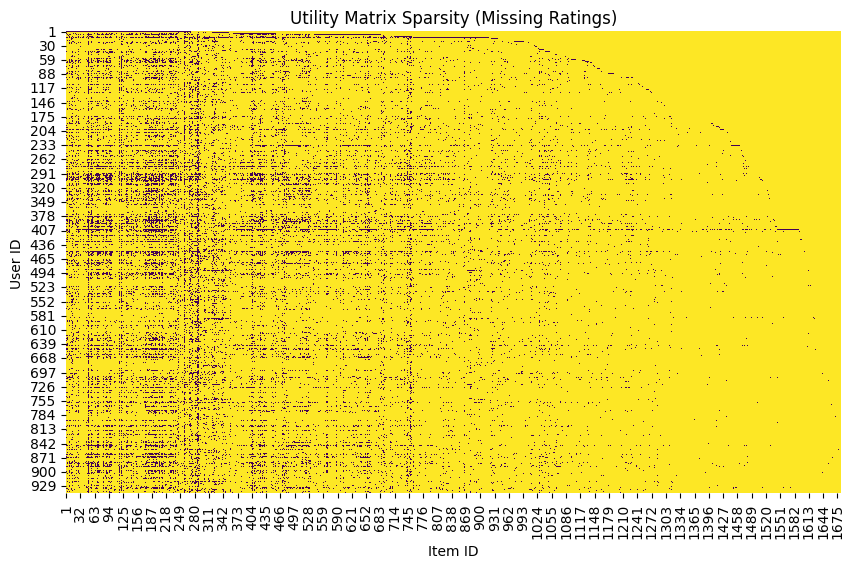

The sparsity of the utility matrix：93.70%


In [27]:
plt.figure(figsize=(10, 6))
sns.heatmap(utility.isnull(), cbar=False, cmap='viridis') # isnull() 返回 True/False 矩阵
plt.title('Utility Matrix Sparsity (Missing Ratings)')
plt.xlabel('Item ID')
plt.ylabel('User ID')
plt.savefig("images/Utility Matrix Sparsity.png")
plt.show()
# 或者更简单地打印出稀疏度比例
total_elements = utility.size
non_null_elements = utility.count().sum()
sparsity = 1 - (non_null_elements / total_elements)
print(f"The sparsity of the utility matrix：{sparsity:.2%}")

In [28]:

user_means = utility.mean(axis=1)

utility_centered = utility.sub(user_means, axis=0)

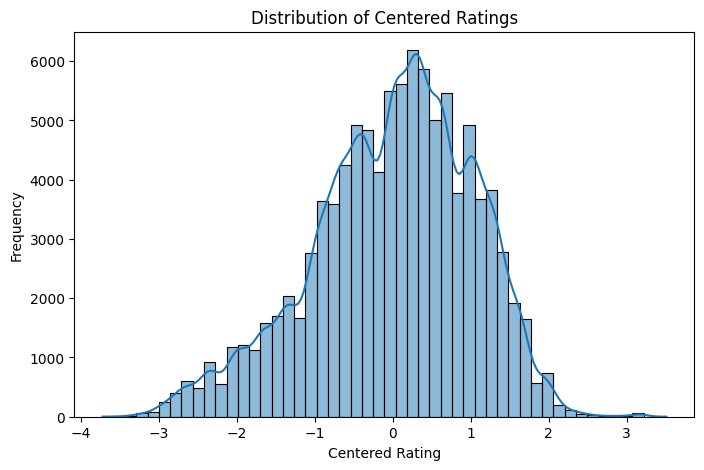

In [36]:
plt.figure(figsize=(8, 5))
sns.histplot(utility_centered.values.flatten(), kde=True, bins=50) # 将所有中心化评分拉平成一维
plt.title('Distribution of Centered Ratings')
plt.xlabel('Centered Rating')
plt.ylabel('Frequency')
plt.savefig("images/Distribution of Centered Ratings.png")
plt.show()

In [30]:
print(utility_centered)

item_id      1         2         3         4         5         6         7     \
user_id                                                                         
1        1.389706 -0.610294  0.389706 -0.610294 -0.610294  1.389706  0.389706   
2        0.290323       NaN       NaN       NaN       NaN       NaN       NaN   
3             NaN       NaN       NaN       NaN       NaN       NaN       NaN   
4             NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5        1.125714  0.125714       NaN       NaN       NaN       NaN       NaN   
...           ...       ...       ...       ...       ...       ...       ...   
939           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
940           NaN       NaN       NaN -1.457944       NaN       NaN  0.542056   
941      0.954545       NaN       NaN       NaN       NaN       NaN -0.045455   
942           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
943           NaN  1.589286 

In [31]:
# 3. 计算用户相似度

uc = utility_centered.fillna(0)

cos_sim = cosine_similarity(uc)    

sim_df = pd.DataFrame(
    cos_sim,
    index=uc.index,
    columns=uc.index
)

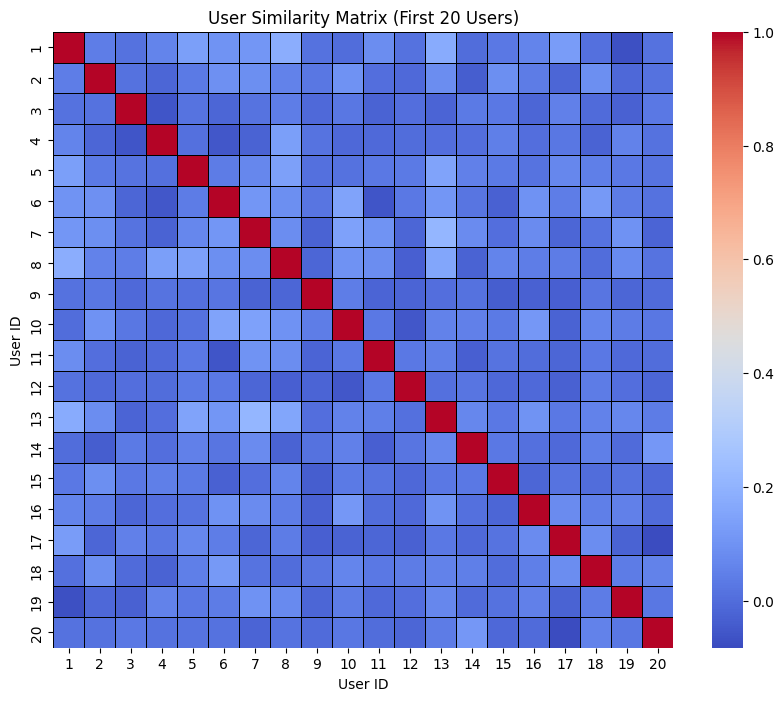

In [32]:
n_users_to_show = 20
plt.figure(figsize=(10, 8))
sns.heatmap(
    sim_df.iloc[:n_users_to_show, :n_users_to_show],
    annot=False,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,  
    linecolor='black' 
)
plt.title(f'User Similarity Matrix (First {n_users_to_show} Users)')
plt.xlabel('User ID')
plt.ylabel('User ID')
plt.savefig("images/User Similarity Matrix.png")
plt.show()

In [33]:
top10 = (
    sim_df.loc[1]              
      .drop(1)                 
      .nlargest(10)            
)
print("The 10 most similar users to User 1 and their similarity:")
print(top10)


The 10 most similar users to User 1 and their similarity:
user_id
773    0.204792
868    0.202321
592    0.196592
880    0.195801
429    0.190661
276    0.187476
916    0.186358
222    0.182415
457    0.182253
8      0.180891
Name: 1, dtype: float64


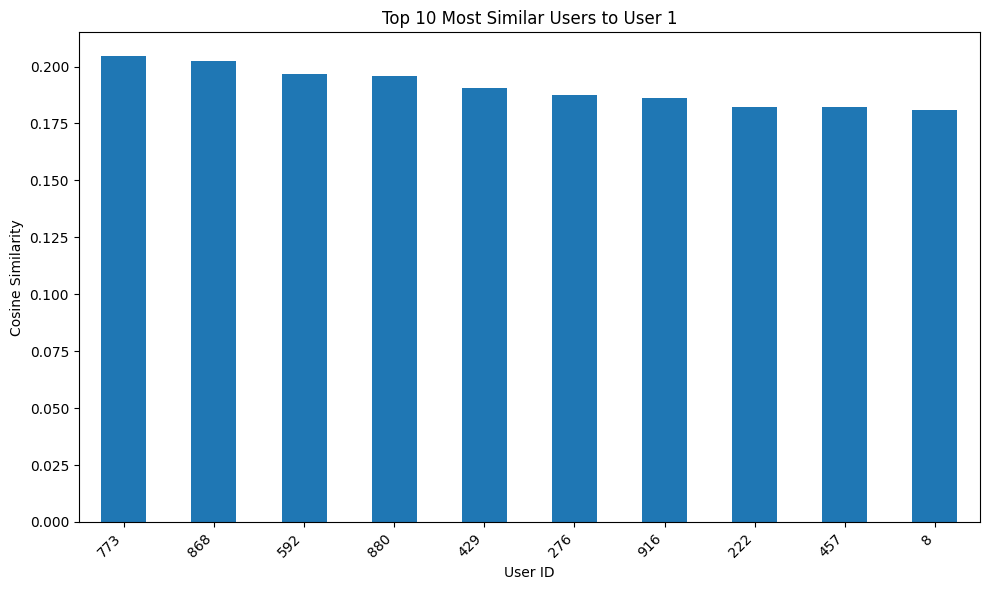

In [34]:
plt.figure(figsize=(10, 6))
top10.plot(kind='bar')
plt.title('Top 10 Most Similar Users to User 1')
plt.xlabel('User ID')
plt.ylabel('Cosine Similarity')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.savefig("images/Top 10 Most Similar Users to User 1.png")
plt.show()

In [35]:
# 5. 基于这10位用户对电影508的评分均值，作预测
#    从原始 ratings 表中筛选这10位用户对 item 508 的实际评分
similar_users = top10.index.tolist()
ratings_508 = ratings[
    (ratings['item_id'] == 508) &
    (ratings['user_id'].isin(similar_users))
]

#    如果这些用户中有的没评分 508，则只基于已评分的计算均值
predicted_rating = ratings_508['rating'].mean()
print(f"\nBased on the average ratings of the movie 508 by these 10 similar users, the predicted rating of User 1 for 508 is：{predicted_rating:.3f}")


Based on the average ratings of the movie 508 by these 10 similar users, the predicted rating of User 1 for 508 is：4.200
